# Data Load

In [7]:
# 라이브러리 임포트 및 GPU 설정
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

# value_round 함수 제거
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor: normalization(tensor, 0, 1))
])

# MNIST 데이터셋 로드
train_dataset = datasets.MNIST(root='./MNIST_dataset', train=True, transform=img_transform, download=True)
test_dataset = datasets.MNIST(root='./MNIST_dataset', train=False, transform=img_transform, download=True)

# 데이터로더 정의
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


# Models

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=20):
        super(Autoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # 인코더
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 2*latent_dim)
        )
        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = h[:, :self.latent_dim]
        logvar = h[:, self.latent_dim:]
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

# Training Functions

In [9]:
def train_ae(model, dataloader, epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if epoch % 10 == 0 or (epoch + 1) == epochs:
            print(f"AE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def train_vae(model, dataloader, epochs=20, lr=1e-3, beta=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            
            # 모델 순전파
            recon, mu, logvar = model(data)
            
            # 재구성 손실 (Mean Squared Error)
            recon_loss = nn.functional.mse_loss(recon, data, reduction='sum')
            
            # KL 발산 계산
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # KL 발산 정규화: 배치 크기와 잠재 변수 차원 수로 나눔
            batch_size = data.size(0)
            latent_dim = mu.size(1)
            kl_loss_normalized = kl_loss / (batch_size * latent_dim)
            
            # 총 손실: 재구성 손실 + beta * 정규화된 KL 발산
            loss = recon_loss + beta * kl_loss_normalized
            loss.backward()
            optimizer.step()
            
            # 손실 누적
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss_normalized.item()
        
        # 에포크당 평균 손실 계산
        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = total_recon / len(dataloader.dataset)
        avg_kl = total_kl / len(dataloader.dataset)
        
        # 로그 출력: 10 에포크마다 또는 마지막 에포크에서 출력
        if epoch % 10 == 0 or (epoch + 1) == epochs:
            print(f"VAE Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}")

# 테스트 데이터에서 두 개의 샘플 선택 (예: 클래스 1과 7)
def get_samples(dataset, class1, class2):
    sample1 = None
    sample2 = None
    for data, label in dataset:
        if label == class1 and sample1 is None:
            sample1 = data
        elif label == class2 and sample2 is None:
            sample2 = data
        if sample1 is not None and sample2 is not None:
            break
    if sample1 is None or sample2 is None:
        raise ValueError(f"Couldn't find samples for classes {class1} and {class2}")
    return sample1.unsqueeze(0), sample2.unsqueeze(0)

# Training

In [10]:
# 잠재 공간 차원, epoch 수, learning rate 설정
latent_dim = 20
epochs = 50
lr = 1e-3
beta = 2.5

# AE 모델 초기화 및 학습
ae_model = Autoencoder(latent_dim=latent_dim)
print("Training Autoencoder...")
train_ae(ae_model, train_loader, epochs=epochs, lr=lr)

# VAE 모델 초기화 및 학습
vae_model = VAE(latent_dim=latent_dim)
print("\nTraining Variational Autoencoder...")
train_vae(vae_model, train_loader, epochs=epochs, lr=lr, beta=beta)


Training Autoencoder...
AE Epoch [1/50], Loss: 0.0930
AE Epoch [11/50], Loss: 0.0154
AE Epoch [21/50], Loss: 0.0124
AE Epoch [31/50], Loss: 0.0112
AE Epoch [41/50], Loss: 0.0104
AE Epoch [50/50], Loss: 0.0099

Training Variational Autoencoder...
VAE Epoch [1/50], Loss: 71.7351, Recon: 71.7156, KL: 0.0078
VAE Epoch [11/50], Loss: 12.5358, Recon: 12.4847, KL: 0.0204
VAE Epoch [21/50], Loss: 9.7948, Recon: 9.7467, KL: 0.0192
VAE Epoch [31/50], Loss: 8.7582, Recon: 8.7117, KL: 0.0186
VAE Epoch [41/50], Loss: 8.0507, Recon: 8.0055, KL: 0.0181
VAE Epoch [50/50], Loss: 7.5833, Recon: 7.5392, KL: 0.0176


# Interpolation Test

In [14]:
def interpolate(class1, class2):
    # 클래스 1, 2의 샘플 가져오기
    sample1, sample2 = get_samples(test_dataset, class1=class1, class2=class2)
    sample1, sample2 = sample1.to(device), sample2.to(device)

        # 결과 시각화 함수
    def show_samples(samples):
        n = len(samples)
        plt.figure(figsize=(n * 2, 2))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Sample 1 & 2(Class {class1} & {class2})")
        plt.show()

    show_samples([sample1, sample2])

    # AE 잠재 벡터 추출 (배치 차원 제거)
    ae_model.eval()
    with torch.no_grad():
        z_ae1 = ae_model.encoder(sample1).cpu().numpy().squeeze(0)  # [20]
        z_ae2 = ae_model.encoder(sample2).cpu().numpy().squeeze(0)  # [20]

    # VAE 잠재 벡터 추출 (평균 벡터 사용, 배치 차원 제거)
    vae_model.eval()
    with torch.no_grad():
        mu1, _ = vae_model.encode(sample1)
        mu2, _ = vae_model.encode(sample2)
        z_vae1 = mu1.cpu().numpy().squeeze(0)  # [20]
        z_vae2 = mu2.cpu().numpy().squeeze(0)  # [20]

    def interpolate(z1, z2, steps=5):
        ratios = np.linspace(0, 1, steps)
        interpolated = []
        for ratio in ratios:
            z = z1 * (1 - ratio) + z2 * ratio
            interpolated.append(z)
        return np.array(interpolated)  # [steps, latent_dim]

    # AE 보간 벡터
    interp_ae = interpolate(z_ae1, z_ae2, steps=10)

    # VAE 보간 벡터
    interp_vae = interpolate(z_vae1, z_vae2, steps=10)

    # 보간된 벡터를 이미지로 복원
    # AE 보간 이미지 생성
    interp_ae = torch.tensor(interp_ae).float().to(device)
    with torch.no_grad():
        recon_ae = ae_model.decoder(interp_ae).cpu()

    # VAE 보간 이미지 생성
    interp_vae = torch.tensor(interp_vae).float().to(device)
    with torch.no_grad():
        recon_vae = vae_model.decode(interp_vae).cpu()

    # 결과 시각화 함수
    def show_images(images, title):
        n = len(images)
        plt.figure(figsize=(n * 2, 2))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

    # AE 보간 결과 시각화
    ae_images = recon_ae.numpy()
    show_images(ae_images, "AE Interpolation")

    # VAE 보간 결과 시각화
    vae_images = recon_vae.numpy()
    show_images(vae_images, "VAE Interpolation")

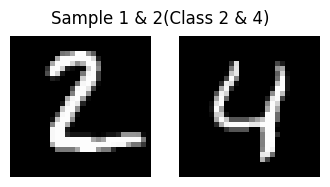

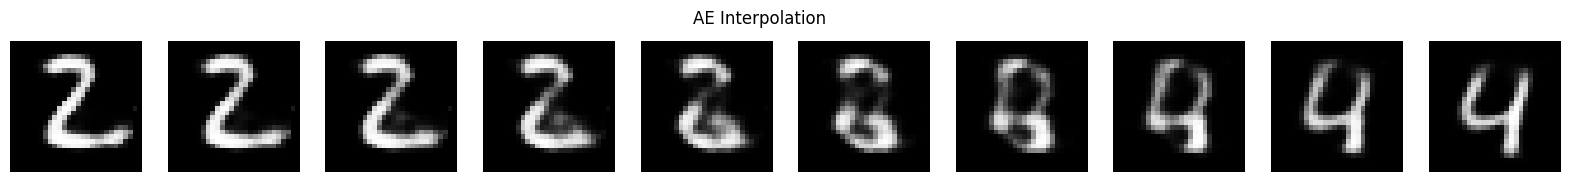

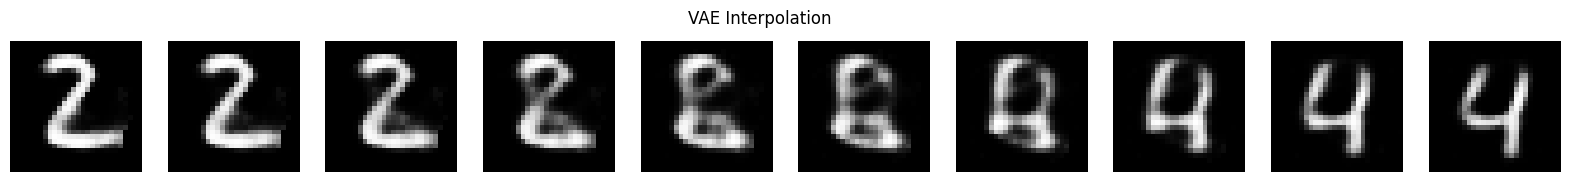

In [19]:
class1, class2 = 2, 4
interpolate(class1, class2)